## EE 782: Advanced Topics in Machine Learning
### **Course Project** Person Re-Identification through SSL using DINO

### Collaborators: 
[![Munish](https://img.shields.io/badge/22M2153-Munish_Monga-blue)](https://github.com/munish30monga)
[![Uddeshya](https://img.shields.io/badge/22M2152-Uddeshya_Singh-darkgreen)](https://github.com/uddeshya-iitb)

> [Github Repo Link](https://github.com/munish30monga/person_ReID)

### Table of Contents:
- [Introduction](#introduction)
- [Importing Libraries](#importing-libraries)
- [Hyperparameters](#hyperparameters)


### Introduction <a id="introduction"></a>

### Importing Libraries <a id="importing-libraries"></a>

In [1]:
import random                                                       # for random number generation
import matplotlib.pyplot as plt                                     # for plotting 
import os                                                           # for file handling
import torch                                                        # for deep learning functionality
from prettytable import PrettyTable                                 # for table formatting
import matplotlib.image as mpimg                                    # for image plotting
import pathlib as pl                                                # for path handling.
import shutil                                                       # for file handling
from torchreid import models, utils                                 # for deep learning functionality
import torchreid                                                    # for deep learning functionality
import torchvision.models as models                                 # for deep learning functionality
import torch.nn as nn                                               # for deep learning functionality
import sys                                                          # for system functionality
sys.path.append('./dino/')                                          # for path handling.
from vision_transformer import DINOHead                             # for deep learning functionality  
from torchvision import models as torchvision_models                # for deep learning functionality
from utils import MultiCropWrapper                                  # for deep learning functionality
from collections import OrderedDict                                 # for deep learning functionality   
from torchsummary import summary                                    # for model summary                                

/home/cminds/miniconda3/envs/dino_env/lib/python3.11/site-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


### Hyperparameters <a id="hyperparameters"></a>

In [2]:
batch_size = 64                                                             # batch size for training
random_seed = 42                                                            # for reproducibility
random.seed(random_seed)                                                    # set random seed
epochs = 20                                                                 # number of epochs to train
learning_rate = 0.0003                                                      # learning rate for optimizer
base_model = 'resnet50'                                                     # base model for training DINO

### GPU Config <a id="gpu-config"></a>

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'                                     # set visible cuda device
device = 'cuda' if torch.cuda.is_available() else 'cpu'                     # set device to cuda if available
table = PrettyTable()
table.field_names = ["CUDA", "GPU", "Total Memory (MB)"]
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        total_memory = torch.cuda.get_device_properties(i).total_memory / (1024 * 1024)
        table.add_row([f"CUDA:{i}", torch.cuda.get_device_name(i), f"{total_memory:.2f}"])
        print(table)
else:
    print("No GPU available.")

+--------+------------------+-------------------+
|  CUDA  |       GPU        | Total Memory (MB) |
+--------+------------------+-------------------+
| CUDA:0 | NVIDIA RTX A6000 |      48668.94     |
+--------+------------------+-------------------+


### Working Directories <a id="working-directories"></a>

In [4]:
dataset_dir = pl.Path("./dataset")                                          # set dataset directory
pa100k_dir = dataset_dir / "PA-100K/imgs"                                   # set pa100k imgs directory
market1501_dir = dataset_dir / "Market-1501-v15.09.15/"                     # set market1501 imgs directory

In [5]:
def copy_images(num_images, data_dir):
    # Define target directory based on the name of data_dir
    target_dir = pl.Path(data_dir.parent / f"dino_training_imgs")
    
    # Create the target directory if it doesn't exist
    target_dir.mkdir(parents=True, exist_ok=True)

    # Get a list of image filenames
    image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))

    # Copy the specified number of images
    for img_path in image_files[:num_images]:
        shutil.copy(img_path, target_dir)

    print(f"{len(list(target_dir.glob('*.jpg')))} images copied to '{target_dir}'")

In [6]:
copy_images(100000, pa100k_dir)

100000 images copied to 'dataset/PA-100K/dino_training_imgs'


### Visualizing Datasets <a id="visualizing-pa-100k-dataset"></a>

In [6]:
def visualize_dataset(data_dir, title):

    # Get a list of all image filenames in the directory
    image_files = [f for f in data_dir.glob('*.jpg')] + [f for f in data_dir.glob('*.png')]

    # Randomly select 32 images
    selected_images = random.sample(image_files, 32)

    # Create a 4x8 grid for displaying the images
    fig, axes = plt.subplots(4, 8, figsize=(15, 10))

    for ax, img_path in zip(axes.ravel(), selected_images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Turn off axis numbers

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)  # Add title in bold
    plt.show()

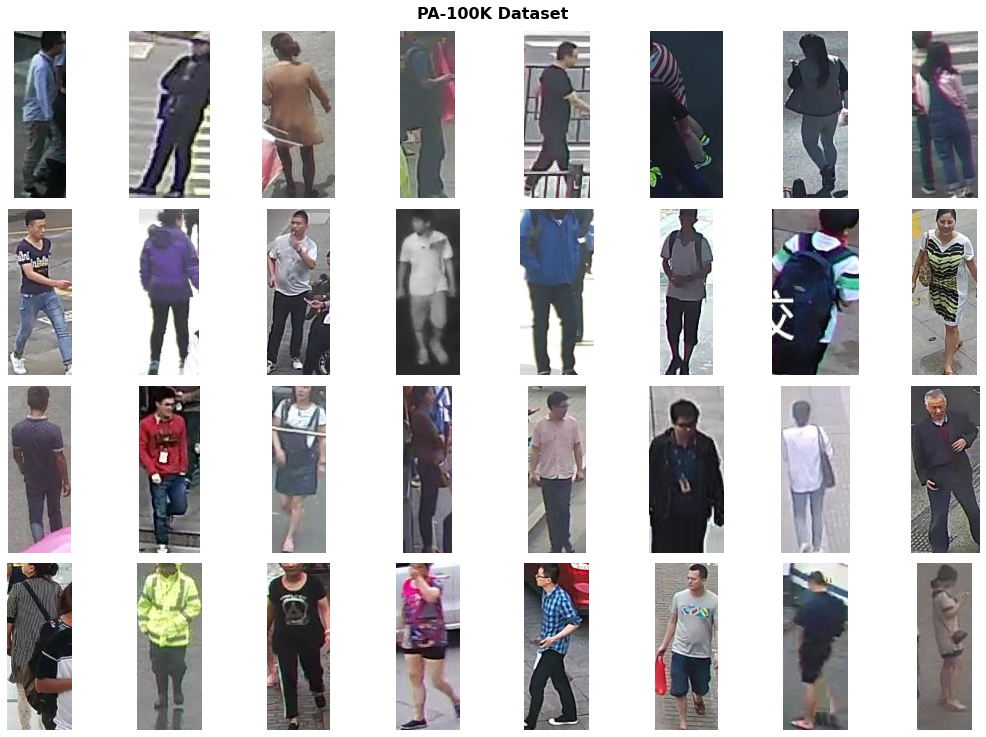

In [6]:
# visualize_dataset(pa100k_dir, "PA-100K Dataset")

### Pre-processing PA-100K Dataset <a id="pre-processing-pa-100k-dataset"></a>

In [7]:
def preprocess_dataset_for_dino(data_dir, n_classes):
    
    imgs_dir = pl.Path(data_dir.parent / "dino_training_imgs")

    # Create a directory for processed data
    processed_dir = data_dir.parent / "processed_dino"
    processed_dir.mkdir(exist_ok=True)

    # List all image files in the directory
    all_files = list(imgs_dir.glob('*'))  # Adjust this pattern if needed, e.g., '*.jpg'
    all_files = [f for f in all_files if f.is_file() and f.name != "processed"]

    # Divide the images into n_classes
    files_per_class = len(all_files) // n_classes
    
    for i in range(n_classes):
        class_dir = processed_dir / f"class_{i}"
        class_dir.mkdir(exist_ok=True)
        
        start_idx = i * files_per_class
        end_idx = (i + 1) * files_per_class if i != n_classes - 1 else len(all_files)  # Use the rest for the last class
        
        for f in all_files[start_idx:end_idx]:
            shutil.copy(f, class_dir / f.name)
    
    print(f"{len(all_files)} images divided into {n_classes} classes and saved to {processed_dir}")
    return processed_dir

In [8]:
preprocess_dataset_for_dino(pa100k_dir, 10)

100000 images divided into 10 classes and saved to dataset/PA-100K/processed_dino


PosixPath('dataset/PA-100K/processed_dino')

### Training DINO with Custom PA-100K Dataset <a id="training-dino-with-custom-pa-100k-dataset"></a>

```python
python main_dino.py --arch resnet50 --optimizer sgd --lr 0.03 --weight_decay 1e-4 --weight_decay_end 1e-4 --global_crops_scale 0.14 1 --local_crops_scale 0.05 0.14 --data_path ./dataset/PA-100K/processed_dino --output_dir ./dino_output
```

### TorchReID DataManager (Market1501 Dataset) <a id="torchreid-datamanager-market1501"></a>

In [8]:
datamanager = torchreid.data.ImageDataManager(
    root=dataset_dir,
    sources="market1501",
    targets="market1501",
    height=256,
    width=128,
    batch_size_train=32,
    batch_size_test=100,
    transforms=["random_flip", "random_crop"],
    combineall=False,
)

Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset


/home/cminds/miniconda3/envs/dino_env/lib/python3.11/site-packages/torchreid/reid/data/datasets/image/market1501.py:37: UserWarning: The current data structure is deprecated. Please put data folders such as "bounding_box_train" under "Market-1501-v15.09.15".
  warnings.warn(


=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------


  **************** Summary ****************
  source            : ['market1501']
  # source datasets : 1
  # source ids      : 751
  # source images   : 12936
  # source cameras  : 6
  target            : ['market1501']
  *****************************************




In [31]:
def load_pretrained_dino_model(base_model, checkpoint_path):
    student = torchvision_models.__dict__[base_model]()
    embed_dim = student.fc.weight.shape[1]
    student = MultiCropWrapper(student, DINOHead(
        embed_dim,
        65536,
        use_bn=False,
        norm_last_layer=True,
    ))
    student = student.to(device)
    saved_state_dict = torch.load(checkpoint_path, map_location=device)
    new_state_dict = OrderedDict()
    for k, v in saved_state_dict["student"].items():
        name = k[7:]  # remove "module." prefix
        new_state_dict[name] = v
    student.load_state_dict(new_state_dict)
    return student

In [32]:
dino_model = load_pretrained_dino_model(base_model, "../person_ReID/best_model/checkpoint.pth").to(device)
summary(dino_model, (3, 256, 128))

/home/cminds/miniconda3/envs/dino_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 64]           9,408
       BatchNorm2d-2          [-1, 64, 128, 64]             128
              ReLU-3          [-1, 64, 128, 64]               0
         MaxPool2d-4           [-1, 64, 64, 32]               0
            Conv2d-5           [-1, 64, 64, 32]           4,096
       BatchNorm2d-6           [-1, 64, 64, 32]             128
              ReLU-7           [-1, 64, 64, 32]               0
            Conv2d-8           [-1, 64, 64, 32]          36,864
       BatchNorm2d-9           [-1, 64, 64, 32]             128
             ReLU-10           [-1, 64, 64, 32]               0
           Conv2d-11          [-1, 256, 64, 32]          16,384
      BatchNorm2d-12          [-1, 256, 64, 32]             512
           Conv2d-13          [-1, 256, 64, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [33]:
def extract_vanilla_resnet50(pretrained_model, unfreeze_last_n):
    # Create a new vanilla ResNet-50 model
    resnet50 = torchvision_models.resnet50(pretrained=False)
    
    # Copy the weights from the pretrained model (excluding the DINO head)
    state_dict_pretrained = pretrained_model.state_dict()
    state_dict_resnet50 = resnet50.state_dict()
    
    # We use a simple prefix matching to copy weights. 
    # This assumes that the structure of your provided model matches torchvision's ResNet50
    for name, param in state_dict_resnet50.items():
        if name in state_dict_pretrained:
            state_dict_resnet50[name] = state_dict_pretrained[name]
    
    resnet50.load_state_dict(state_dict_resnet50)
        # Handle unfreezing of layers
        
    if unfreeze_last_n == -1:
        # Make all layers trainable
        for param in resnet50.parameters():
            param.requires_grad = True
            
    elif unfreeze_last_n == 0:
        # Make all layers frozen
        for param in resnet50.parameters():
            param.requires_grad = False
            
    else:
        # Freeze all layers initially
        for param in resnet50.parameters():
            param.requires_grad = False

        # Unfreeze the last n layers
        num_layers = len(list(resnet50.children()))
        for i, child in enumerate(resnet50.children()):
            if i >= num_layers - unfreeze_last_n:
                for param in child.parameters():
                    param.requires_grad = True
                    
    return resnet50

In [35]:
model = extract_vanilla_resnet50(dino_model, unfreeze_last_n=4).to(device)
summary(model, (3, 256, 128))

/home/cminds/miniconda3/envs/dino_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cminds/miniconda3/envs/dino_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 64]           9,408
       BatchNorm2d-2          [-1, 64, 128, 64]             128
              ReLU-3          [-1, 64, 128, 64]               0
         MaxPool2d-4           [-1, 64, 64, 32]               0
            Conv2d-5           [-1, 64, 64, 32]           4,096
       BatchNorm2d-6           [-1, 64, 64, 32]             128
              ReLU-7           [-1, 64, 64, 32]               0
            Conv2d-8           [-1, 64, 64, 32]          36,864
       BatchNorm2d-9           [-1, 64, 64, 32]             128
             ReLU-10           [-1, 64, 64, 32]               0
           Conv2d-11          [-1, 256, 64, 32]          16,384
      BatchNorm2d-12          [-1, 256, 64, 32]             512
           Conv2d-13          [-1, 256, 64, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [36]:
utils.compute_model_complexity(model, (1, 3, 256, 128), verbose=True, only_conv_linear=False)

  -------------------------------------------------------
  Model complexity with input size (1, 3, 256, 128)
  -------------------------------------------------------
  Conv2d (params=23,454,912, flops=2,669,150,208)
  BatchNorm2d (params=53,120, flops=29,032,448)
  ReLU (params=0, flops=6,275,072)
  MaxPool2d (params=0, flops=1,048,576)
  AdaptiveAvgPool2d (params=0, flops=65,536)
  Linear (params=2,049,000, flops=2,049,000)
  -------------------------------------------------------
  Total (params=25,557,032, flops=2,707,620,840)
  -------------------------------------------------------


(25557032, 2707620840)

In [37]:
optimizer = torchreid.optim.build_optimizer(
    model, optim='adam', lr=0.0003
)
scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler='single_step',
    stepsize=20
)
engine = torchreid.engine.ImageSoftmaxEngine(
    datamanager, model, optimizer=optimizer, scheduler=scheduler
)

In [38]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
engine.run(
    max_epoch=20,
    save_dir='log/resnet50-triplet-market1501',
    eval_freq=5,
    print_freq=1,
    test_only=False
)

=> Start training
epoch: [1/20][1/404]	time 1.056 (1.056)	data 0.430 (0.430)	eta 2:22:09	loss 7.4633 (7.4633)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][2/404]	time 0.109 (0.583)	data 0.001 (0.215)	eta 1:18:26	loss 7.3600 (7.4116)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][3/404]	time 0.110 (0.425)	data 0.000 (0.144)	eta 0:57:12	loss 7.3414 (7.3882)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][4/404]	time 0.109 (0.346)	data 0.000 (0.108)	eta 0:46:34	loss 7.6476 (7.4531)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][5/404]	time 0.056 (0.288)	data 0.000 (0.086)	eta 0:38:45	loss 7.7157 (7.5056)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][6/404]	time 0.103 (0.257)	data 0.000 (0.072)	eta 0:34:36	loss 8.0682 (7.5994)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][7/404]	time 0.110 (0.236)	data 0.000 (0.062)	eta 0:31:46	loss 8.4969 (7.7276)	acc 0.0000 (0.0000)	lr 0.000300
epoch: [1/20][8/404]	time 0.109 (0.220)	data 0.000 (0.054)	eta 0:29:38	loss 8.4730 (7.8208)	acc 0.0000 (0.0000)	lr